In [1]:
import pandas as pd
import numpy as np
import warnings
import pmdarima as pm
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
from common.preprocessor import load_data, mape
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error

# %%
import matplotlib.pyplot as plt
# %matplotlib inline
pd.options.display.float_format = '{:,.2f}'.format
np.set_printoptions(precision=2)
warnings.filterwarnings("ignore")

In [2]:
data = pd.read_csv('Modified Data.csv', parse_dates=True, index_col=[0])

In [3]:
data.head()

,Price
2002-01-01,19.96
2002-02-01,20.19
2002-03-01,24.03
2002-04-01,26.03
2002-05-01,25.69


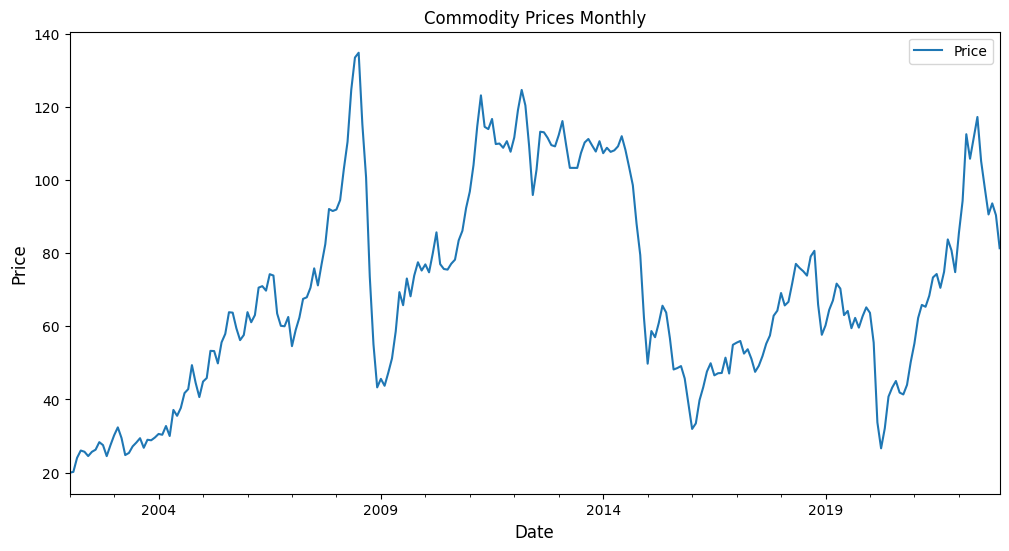

In [4]:
data.plot(y='Price', title='Commodity Prices Monthly', figsize=(12, 6))
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.show()

In [5]:
# Create training and testing datasets
train, test = train_test_split(data, test_size=0.2, shuffle=False)

In [6]:
train.shape, test.shape

((201, 1), (51, 1))

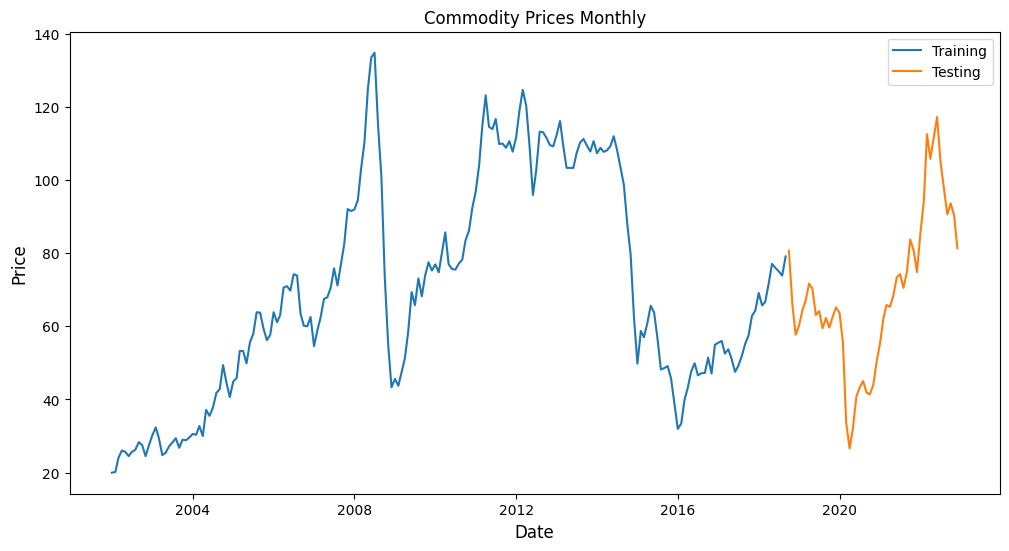

In [7]:
# Visualize the training and testing datasets
plt.figure(figsize=(12, 6))
plt.plot(train, label='Training')
plt.plot(test, label='Testing')
plt.title('Commodity Prices Monthly')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.legend()
plt.show()

In [8]:
# Prepare data for training
scaler = MinMaxScaler()
scaled_train = train.copy()
scaled_test = test.copy()
scaled_train['Price'] = scaler.fit_transform(scaled_train[['Price']])

In [9]:
# Check for stationarity with ADF test
def adf_test(series):
    result = adfuller(series, autolag='AIC')
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    if result[1] <= 0.05:
        print("Data is likely stationary.")
    else:
        print("Data may be non-stationary. Consider differencing.")

print("Testing stationarity of scaled training data:")
adf_test(scaled_train['Price'])

print("\nTesting stationarity of scaled test data:")
adf_test(scaled_test['Price'])

Testing stationarity of scaled training data:
ADF Statistic: -2.4610076050408614
p-value: 0.1252520709317187
Data may be non-stationary. Consider differencing.

Testing stationarity of scaled test data:
ADF Statistic: -1.549083725438425
p-value: 0.509105854815543
Data may be non-stationary. Consider differencing.


In [10]:
# Identify number of differences required (if necessary)
n_diffs = pm.arima.ndiffs(scaled_train['Price'], test='adf')
print(f"\nNumber of differences required for scaled training data: {n_diffs}")

n_diffs = pm.arima.ndiffs(scaled_test['Price'], test='adf')
print(f"\nNumber of differences required for scaled test data: {n_diffs}")


Number of differences required for scaled training data: 1

Number of differences required for scaled test data: 2


In [11]:
# Perform differencing if required
if n_diffs > 0:
    differenced_train = scaled_train.diff(n_diffs).dropna()
    differenced_test = scaled_test.diff(n_diffs).dropna()
else:
    differenced_train = scaled_train.copy()
    differenced_test = scaled_test.copy()

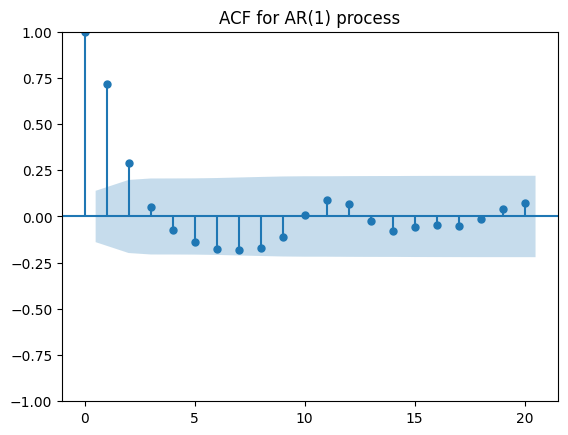

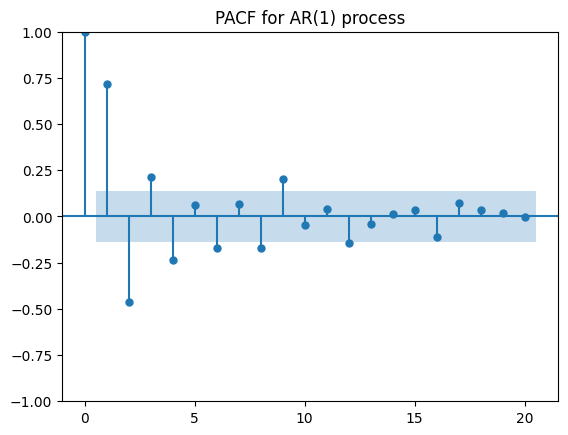

In [12]:
# ACF and PACF plots (optional)
plot_acf(differenced_train['Price'], lags=20, title='ACF for AR(1) process')
plt.show()
plot_pacf(differenced_train['Price'], lags=20, title='PACF for AR(1) process')
plt.show()

In [13]:
# Use auto_arima to find best parameters
model = auto_arima(differenced_train['Price'], start_p=1, start_q=1, max_p=3, max_q=3, m=12,
                  start_P=0, seasonal=True, d=None, max_d=2, D=1, max_D=2, trace=True,
                  error_action='ignore', suppress_warnings=True,
                  stepwise=True)
print(f"\nAuto ARIMA identified parameters: {model.order}, {model.seasonal_order}")

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=1.40 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=-269.383, Time=0.05 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=-436.956, Time=0.66 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=0.56 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=-271.366, Time=0.03 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=-413.670, Time=0.13 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=-454.924, Time=1.37 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=2.01 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=0.98 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=-322.832, Time=0.86 sec
 ARIMA(2,0,0)(2,1,0)[12] intercept   : AIC=-494.748, Time=1.69 sec
 ARIMA(2,0,0)(1,1,0)[12] intercept   : AIC=-471.705, Time=0.47 sec
 ARIMA(2,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=2.84 sec
 ARIMA(2,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=1.16 sec
 ARIMA(3,0,0)(2,1,0)[12] intercept   : AIC=-493.1

In [14]:
# Fit the SARIMA model on the differenced training data
model = SARIMAX(differenced_train, order=model.order, seasonal_order=model.seasonal_order, freq="MS")
model_fit = model.fit(disp=0)  # Suppress convergence output

In [15]:
# Make predictions on the differenced test set
predictions = model_fit.predict(start=differenced_test.index[0], end=differenced_test.index[-1])

In [16]:
# Invert differencing (if applied earlier)
if n_diffs > 0:
    # Invert seasonal differencing
    predictions_diff = pd.Series(predictions, index=differenced_test.index)
    predictions_seasonal = pd.Series(differenced_train.iloc[0]['Price'], index=differenced_train.index)
    predictions_seasonal = predictions_seasonal.add(predictions_diff, fill_value=0).fillna(0)

    # Invert first differencing
    predictions = pd.Series(scaled_test.iloc[0]['Price'], index=scaled_test.index)
    predictions = predictions.add(predictions_seasonal.cumsum(), fill_value=0).fillna(0)
else:
    # No differencing applied, so predictions on scaled test data is sufficient
    predictions = pd.Series(predictions, index=scaled_test.index)

In [17]:
# Invert scaling
predictions = scaler.inverse_transform(predictions.values.reshape(-1, 1))

In [18]:
# Evaluate model performance (using MSE here, consider adding other metrics)
# Ensure that 'predictions' is only as long as 'test'
if len(predictions) > len(test['Price']):
    predictions = predictions[:len(test['Price'])]

mse = mean_squared_error(test['Price'], predictions)
print(f'MSE: {mse}')

MSE: 5714.45102156862


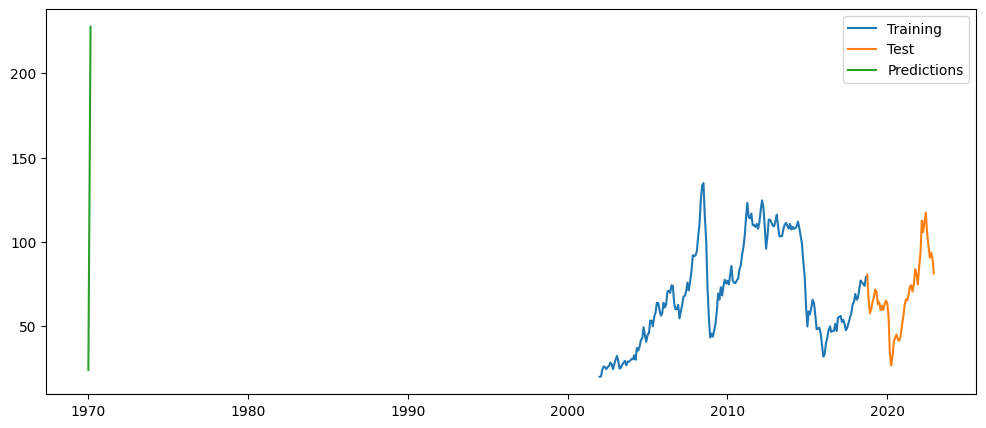

In [19]:
# Plot actual vs predicted values
plt.figure(figsize=(12, 5))
plt.plot(train, label='Training')
plt.plot(test, label='Test')
plt.plot(predictions, label='Predictions')
plt.legend()
plt.show()

# Additional steps (optional):
# - Save the model for future use
# - Implement error handling for potential issues